2024-05-21 21:25:30.492615: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-21 21:25:30.650704: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-21 21:25:31.229680: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 21:25:32.323985: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Number of columns in the dataframe: 742


/home/aleksander.kolodziej@A4BEE.ad/Desktop/EKG_PPG_BP/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


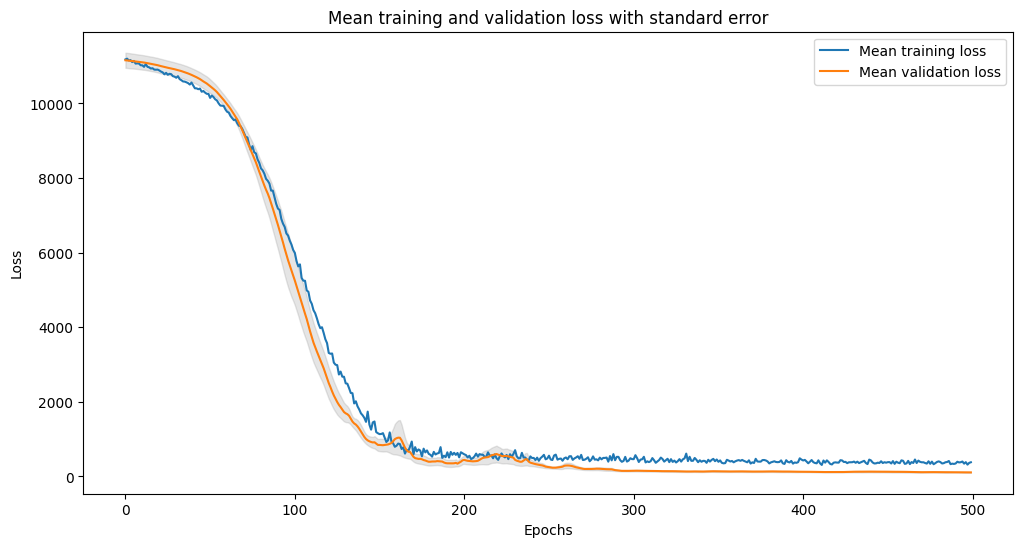

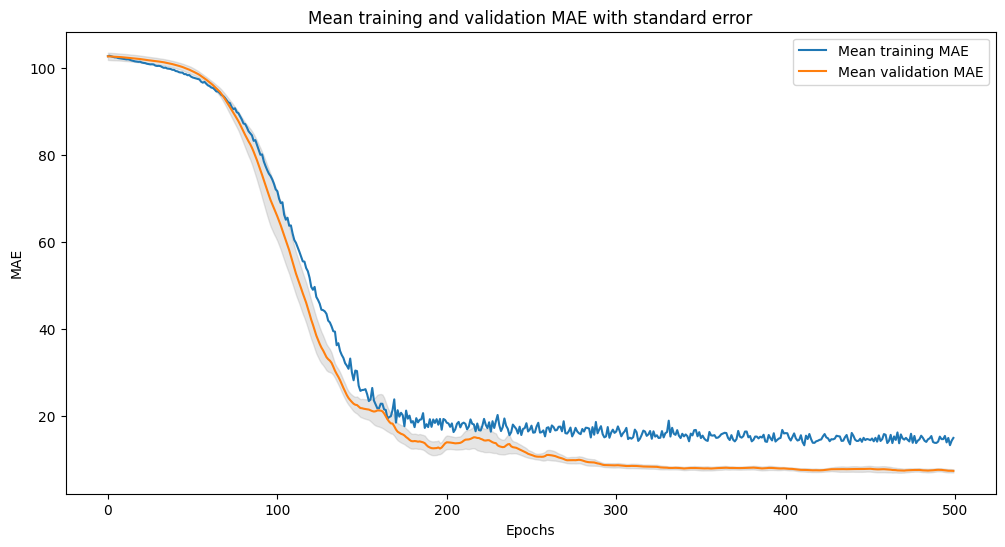

Mean Absolute Error (MAE): 7.270914363861084
Standard Deviation of Error: 0.8096289205121371


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Load the CSV file
df = pd.read_csv('data_to_model.csv')
df = df.drop(columns=["Filename", "Unnamed: 0"])
# Verify the number of columns
print(f"Number of columns in the dataframe: {df.shape[1]}")

# Features and target separation
X = df.iloc[:, :-2].values  # First 740 columns as features
y = df.iloc[:, -2:].values  # Last 2 columns as targets



# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def create_advanced_model(input_dim):
    # Define a Sequential model
    model = Sequential()
    
    # Add layers to the model
    model.add(Dense(input_dim, input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(512, input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
    
    model.add(Dense(2, activation='linear'))  # Output layer with 2 neurons for regression
    
    # Compile the model with optimizer, loss function, and metrics
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

# Initialize variables to store results
train_losses = []
val_losses = []
train_maes = []
val_maes = []

# Lists to store scores for each fold
mae_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = create_advanced_model(input_dim = 740)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=500, batch_size=32, verbose=0, validation_data=(X_test, y_test))
    
    # Evaluate the model
    mse, mae = model.evaluate(X_test, y_test, verbose=0)
    mae_scores.append(mae)
    
    # Append losses and MAE to lists
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    train_maes.append(history.history['mae'])
    val_maes.append(history.history['val_mae'])

# Calculate mean and standard error for losses and MAE for each epoch
mean_train_loss = np.mean(train_losses, axis=0)
mean_val_loss = np.mean(val_losses, axis=0)
mean_train_mae = np.mean(train_maes, axis=0)
mean_val_mae = np.mean(val_maes, axis=0)

std_val_loss = np.std(val_losses, axis=0)
std_val_mae = np.std(val_maes, axis=0)

se_val_loss = std_val_loss / np.sqrt(kf.get_n_splits())
se_val_mae = std_val_mae / np.sqrt(kf.get_n_splits())

# Plot mean losses with standard error for validation loss
plt.figure(figsize=(12, 6))
plt.plot(mean_train_loss, label='Mean training loss')
plt.plot(mean_val_loss, label='Mean validation loss')
plt.fill_between(range(len(mean_val_loss)), mean_val_loss - se_val_loss, mean_val_loss + se_val_loss, color='gray', alpha=0.2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Mean training and validation loss with standard error')
plt.show()

# Plot mean MAE with standard error for validation MAE
plt.figure(figsize=(12, 6))
plt.plot(mean_train_mae, label='Mean training MAE')
plt.plot(mean_val_mae, label='Mean validation MAE')
plt.fill_between(range(len(mean_val_mae)), mean_val_mae - se_val_mae, mean_val_mae + se_val_mae, color='gray', alpha=0.2)
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Mean training and validation MAE with standard error')
plt.show()

# Calculate and display mean MAE and standard deviation of MAE
mean_mae = np.mean(mae_scores)
std_mae = np.std(mae_scores)
print(f'Mean Absolute Error (MAE): {mean_mae}')
print(f'Standard Deviation of Error: {std_mae}')

Number of rows before drop: 119
Number of rows after drop: 119
Number of columns in the dataframe: 742


/home/aleksander.kolodziej@A4BEE.ad/Desktop/EKG_PPG_BP/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Fold 1:
Actual (y_test):
[[117  79]
 [118  80]
 [117  78]
 [116  75]
 [129  87]
 [139  82]
 [128  86]
 [108  81]]

Predicted (y_pred):
[[113.40551   72.06652 ]
 [116.790764  75.24256 ]
 [119.53535   75.668335]
 [122.47532   77.98431 ]
 [127.33874   76.9631  ]
 [119.883385  76.287025]
 [115.47146   73.29461 ]
 [115.3413    74.237495]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


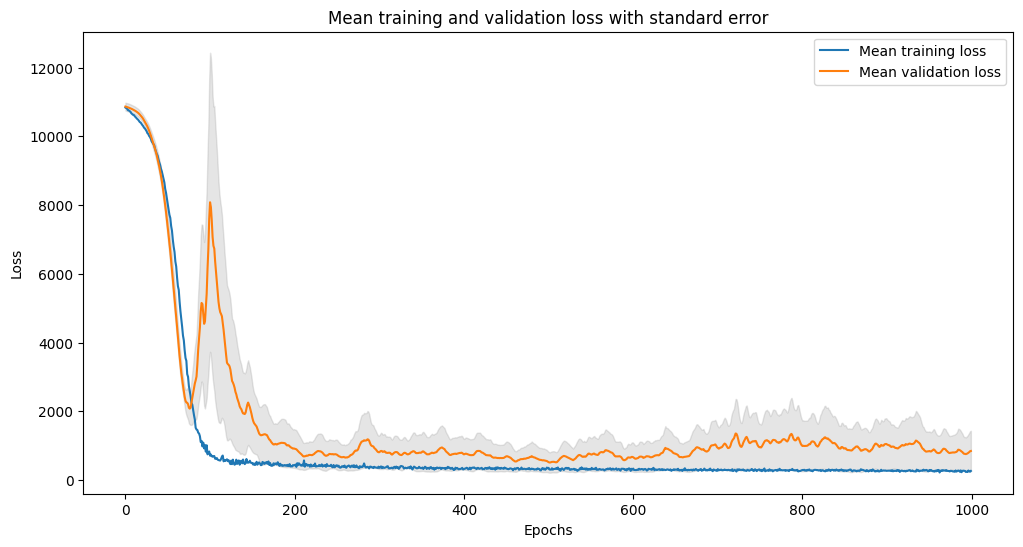

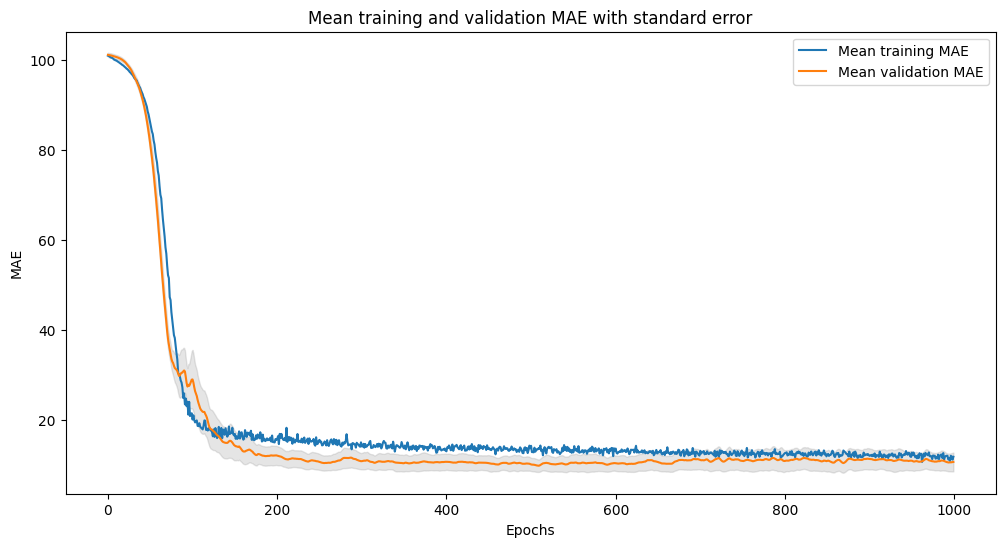

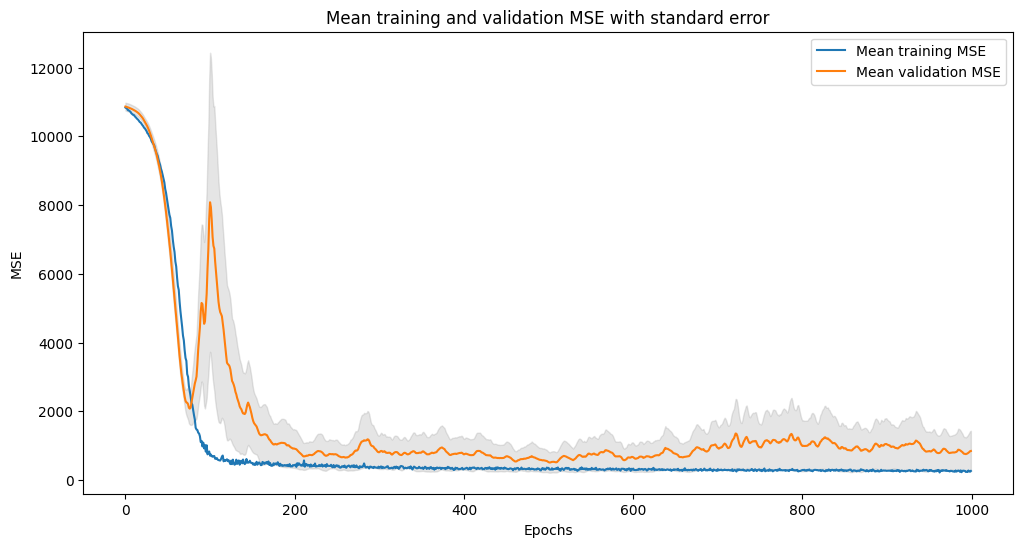

Mean Absolute Error (MAE): 10.773137664794922
Standard Deviation of MAE: 4.665406995507616
Mean Squared Error (MSE): 848.7327407836914
Standard Deviation of MSE: 1316.1235497031548


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Load the CSV file
df = pd.read_csv('data_to_model.csv')
df = df.drop(columns=["Filename", "Unnamed: 0"])
print(f"Number of rows before drop: {df.shape[0]}")
df = df.dropna()
print(f"Number of rows after drop: {df.shape[0]}")
# Verify the number of columns
print(f"Number of columns in the dataframe: {df.shape[1]}")

# Features and target separation
X = df.iloc[:, :-2].values  # First 740 columns as features
y = df.iloc[:, -2:].values  # Last 2 columns as targets

input_size = int(X.shape[1])

scaler = StandardScaler()
X = scaler.fit_transform(X)

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def create_advanced_model(input_dim):
    # Define a Sequential model
    model = Sequential()
    
    # Add layers to the model
    model.add(Dense(input_dim, input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # model.add(Dense(1024, input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.01)))
    # model.add(BatchNormalization())
    # model.add(Dropout(0.5))
    
    model.add(Dense(512, input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
    
    model.add(Dense(2, activation='linear'))  # Output layer with 2 neurons for regression
    
    # Compile the model with optimizer, loss function, and metrics
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

# Initialize variables to store results
train_losses = []
val_losses = []
train_maes = []
val_maes = []
train_mses = []  # New list to store train MSE
val_mses = []    # New list to store validation MSE

# Lists to store scores for each fold
mae_scores = []
mse_scores = []  # New list to store MSE scores

for fold_num, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = create_advanced_model(input_size)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=1000, batch_size=32, verbose=0, validation_data=(X_test, y_test))
    
    # Evaluate the model
    mse, mae = model.evaluate(X_test, y_test, verbose=0)
    mae_scores.append(mae)
    mse_scores.append(mse)  # Append MSE to scores

    # Predict target values
    y_pred = model.predict(X_test)
    
# Print y_test and y_pred from the first fold
    if fold_num == 0:
        print(f"Fold {fold_num+1}:")
        print("Actual (y_test):")
        print(y_test[:8])  # Print first 5 actual values
        print("\nPredicted (y_pred):")
        print(y_pred[:8])  # Print first 5 predicted values
        
    # Append losses, MAE, and MSE to lists
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    train_maes.append(history.history['mae'])
    val_maes.append(history.history['val_mae'])
    train_mses.append(history.history['loss'])  # Append train MSE
    val_mses.append(history.history['val_loss'])  # Append validation MSE


# Calculate mean and standard error for losses, MAE, and MSE for each epoch
mean_train_loss = np.mean(train_losses, axis=0)
mean_val_loss = np.mean(val_losses, axis=0)
mean_train_mae = np.mean(train_maes, axis=0)
mean_val_mae = np.mean(val_maes, axis=0)
mean_train_mse = np.mean(train_mses, axis=0)  # Calculate mean train MSE
mean_val_mse = np.mean(val_mses, axis=0)  # Calculate mean validation MSE

std_val_loss = np.std(val_losses, axis=0)
std_val_mae = np.std(val_maes, axis=0)
std_val_mse = np.std(val_mses, axis=0)  # Calculate standard deviation for validation MSE

se_val_loss = std_val_loss / np.sqrt(kf.get_n_splits())
se_val_mae = std_val_mae / np.sqrt(kf.get_n_splits())
se_val_mse = std_val_mse / np.sqrt(kf.get_n_splits())  # Calculate standard error for validation MSE

# Plot mean losses with standard error for validation loss
plt.figure(figsize=(12, 6))
plt.plot(mean_train_loss, label='Mean training loss')
plt.plot(mean_val_loss, label='Mean validation loss')
plt.fill_between(range(len(mean_val_loss)), mean_val_loss - se_val_loss, mean_val_loss + se_val_loss, color='gray', alpha=0.2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Mean training and validation loss with standard error')
plt.show()

# Plot mean MAE with standard error for validation MAE
plt.figure(figsize=(12, 6))
plt.plot(mean_train_mae, label='Mean training MAE')
plt.plot(mean_val_mae, label='Mean validation MAE')
plt.fill_between(range(len(mean_val_mae)), mean_val_mae - se_val_mae, mean_val_mae + se_val_mae, color='gray', alpha=0.2)
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Mean training and validation MAE with standard error')
plt.show()

# Plot mean MSE with standard error for validation MSE
plt.figure(figsize=(12, 6))
plt.plot(mean_train_mse, label='Mean training MSE')
plt.plot(mean_val_mse, label='Mean validation MSE')
plt.fill_between(range(len(mean_val_mse)), mean_val_mse - se_val_mse, mean_val_mse + se_val_mse, color='gray', alpha=0.2)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.title('Mean training and validation MSE with standard error')
plt.show()

# Calculate and display mean MAE, MSE, and standard deviation of MAE and MSE
mean_mae = np.mean(mae_scores)
std_mae = np.std(mae_scores)
mean_mse = np.mean(mse_scores)  # Calculate mean MSE
std_mse = np.std(mse_scores)  # Calculate standard deviation of MSE
print(f'Mean Absolute Error (MAE): {mean_mae}')
print(f'Standard Deviation of MAE: {std_mae}')
print(f'Mean Squared Error (MSE): {mean_mse}')
print(f'Standard Deviation of MSE: {std_mse}')